# Post Test set

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_post_dataset/test/9353628_20140129_MOLLI_1.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
# low, sparse, U, S, V = rpca_godec(M, rank=5)
# low_matrix = low.reshape((x, y, z))
# sparse_matrix = sparse.reshape((x, y, z))

# fig = plt.figure(figsize=(11, 3))
# title_font_size=8
# title_pad = 10
# for i in range(z):
#     ax1 = fig.add_subplot(3, 11, 1+i)
#     plt.imshow(vols[..., i], cmap='gray')
#     plt.axis('off')
#     ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

#     ax2 = fig.add_subplot(3, 11, 12+i)
#     plt.imshow(low_matrix[..., i], cmap='gray')
#     plt.axis('off')

#     ax3 = fig.add_subplot(3, 11, 23+i)
#     plt.imshow(sparse_matrix[..., i], cmap='gray')
#     plt.axis('off')

x is 224 and y is 224 and z is 11
(50176, 11)


In [2]:
import pandas as pd
df = pd.DataFrame()
df_2 = pd.DataFrame()

## Test Metrics

### Original volume

#### First Eigen Component percentage

In [3]:
from scripts.utils import *
orig_path = 'data/MOLLI_post_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.8590354716904918


#### T1 fitting

In [4]:
import scipy.io
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

title_font_size=8
title_pad = 10
def plot_t1_changes(path, size=(20, 36)):
    fig = plt.figure(figsize=size)
    t1err_square_list = []
    t1err_heart_list = []
    t1err_myo_list = []
    subject_list = []
    
    neighbor = ndimage.generate_binary_structure(2, 2)
    for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
        subject = Path(file).stem
        subject_list.append(subject)
        fd = scipy.io.loadmat(file)
        SD_err = fd['S']
        areamask = fd['areamask']
        itemindex = np.where(areamask == 1)
        x1, x2 = itemindex[0][0], itemindex[0][-1]
        y1, y2 = itemindex[1][0], itemindex[1][-1]
        epi = fd['epi_BW']
        endo = fd['endo_BW']
        heartmask = ndimage.binary_dilation(epi, structure=neighbor, iterations=2).astype(epi.dtype)
        myomask = heartmask - endo
        
        errmap = SD_err * areamask
        square_SD_err = np.mean(errmap[areamask==1])
        t1err_square_list.append(square_SD_err)
        fig.add_subplot(10, 6, 1+i*6)
        ax = plt.gca()
        im = ax.imshow(errmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(square_SD_err):.4f}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        t1_params_pre = fd['pmap_mse']
        a = t1_params_pre[:, :, 0]
        b = t1_params_pre[:, :, 1]
        c = t1_params_pre[:, :, 2]
        t1map = c * (b - 1)
        fig.add_subplot(10, 6, 2+i*6)
        ax = plt.gca()
        im = ax.imshow(t1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=1500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        hearterrmap = SD_err * heartmask
        heartt1map = t1map * heartmask
        heart_SD_err = np.mean(hearterrmap[heartmask==1])
        t1err_heart_list.append(heart_SD_err)

        fig.add_subplot(10, 6, 3+i*6)
        ax = plt.gca()
        im = ax.imshow(hearterrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(heart_SD_err):.4f} in ROI", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        fig.add_subplot(10, 6, 4+i*6)
        ax = plt.gca()
        im = ax.imshow(heartt1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=1500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        myoerrmap = SD_err * myomask
        myot1map = t1map * myomask
        myo_SD_err = np.mean(myoerrmap[myomask==1])
        t1err_myo_list.append(myo_SD_err)

        fig.add_subplot(10, 6, 5+i*6)
        ax = plt.gca()
        im = ax.imshow(myoerrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(myo_SD_err):.4f} in Myocardium", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        fig.add_subplot(10, 6, 6+i*6)
        ax = plt.gca()
        im = ax.imshow(myot1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
    return fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list

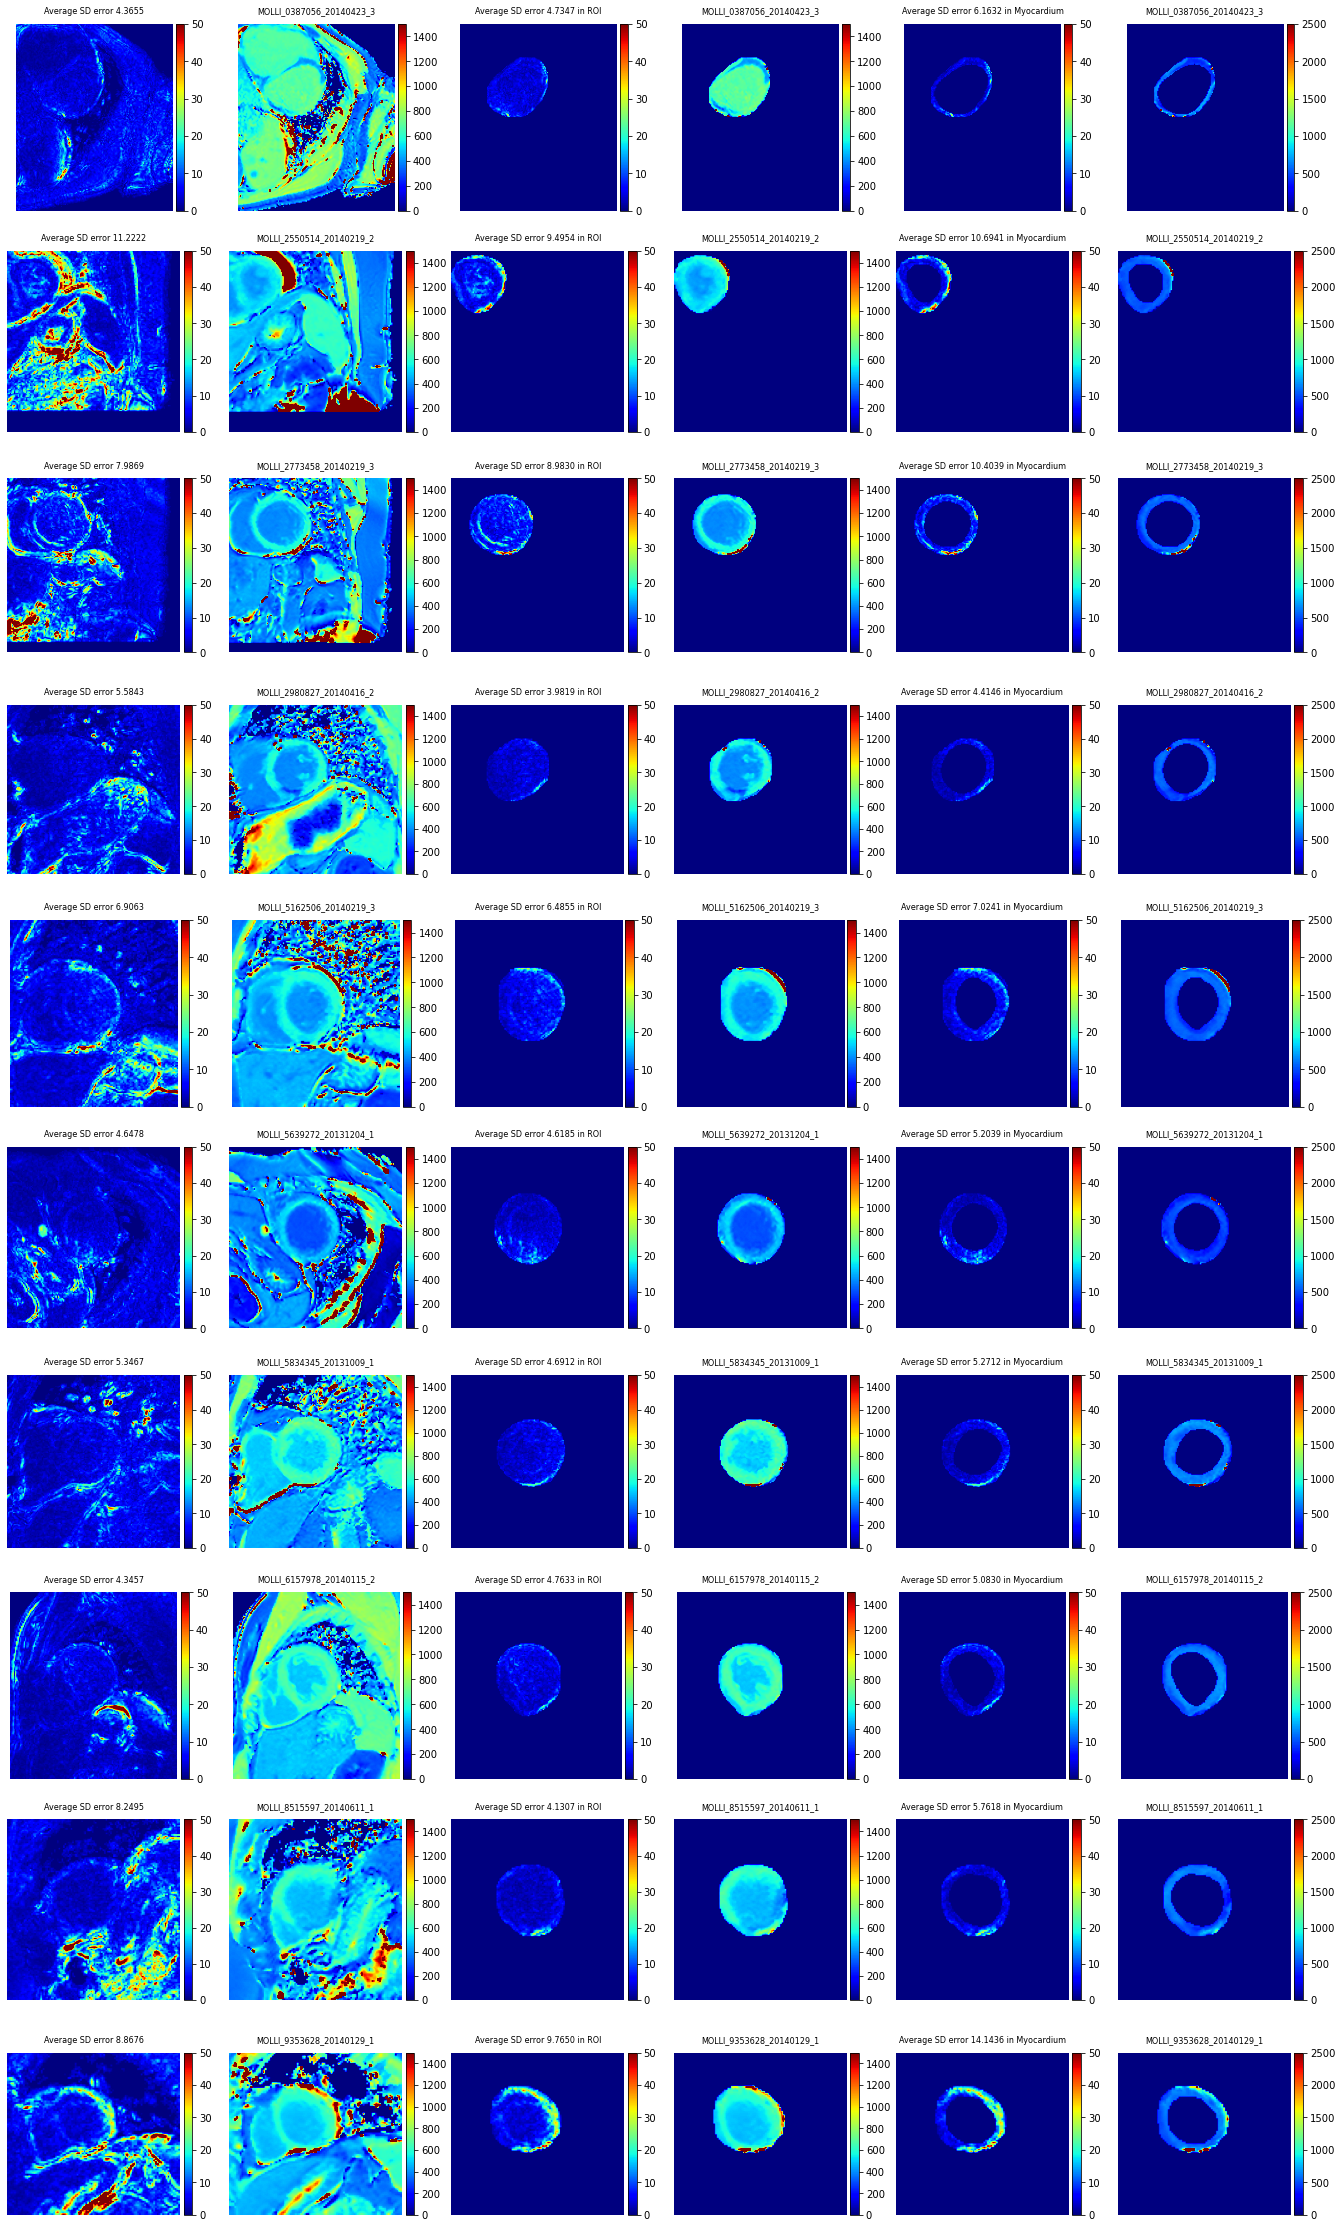

In [5]:
path = "data/MOLLI_post_dataset/T1_SDerr"

fig, subject_list, orig_t1err_square_list, orig_t1err_heart_list, orig_t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"data/MOLLI_post_dataset/T1_SDerr/orig_t1err.png", dpi=300)

df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['Raw ROI T1err'] = orig_t1err_heart_list
df['Raw Myo T1err'] = orig_t1err_myo_list
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes

### Round 1

In [6]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

In [7]:
r = 1
root = f"results/MOLLI_pre/Group/rank_11_5_5_5_5_5_5/nmi/smooth/image_loss_weight1/cycle_loss_weight0.01/weight0.001/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_post"
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [8]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 1 PCA is 0.8638835927428286 and std is 0.021358224332192106


#### Jacobian Determination

In [9]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0020724923815578222


#### T1 fitting

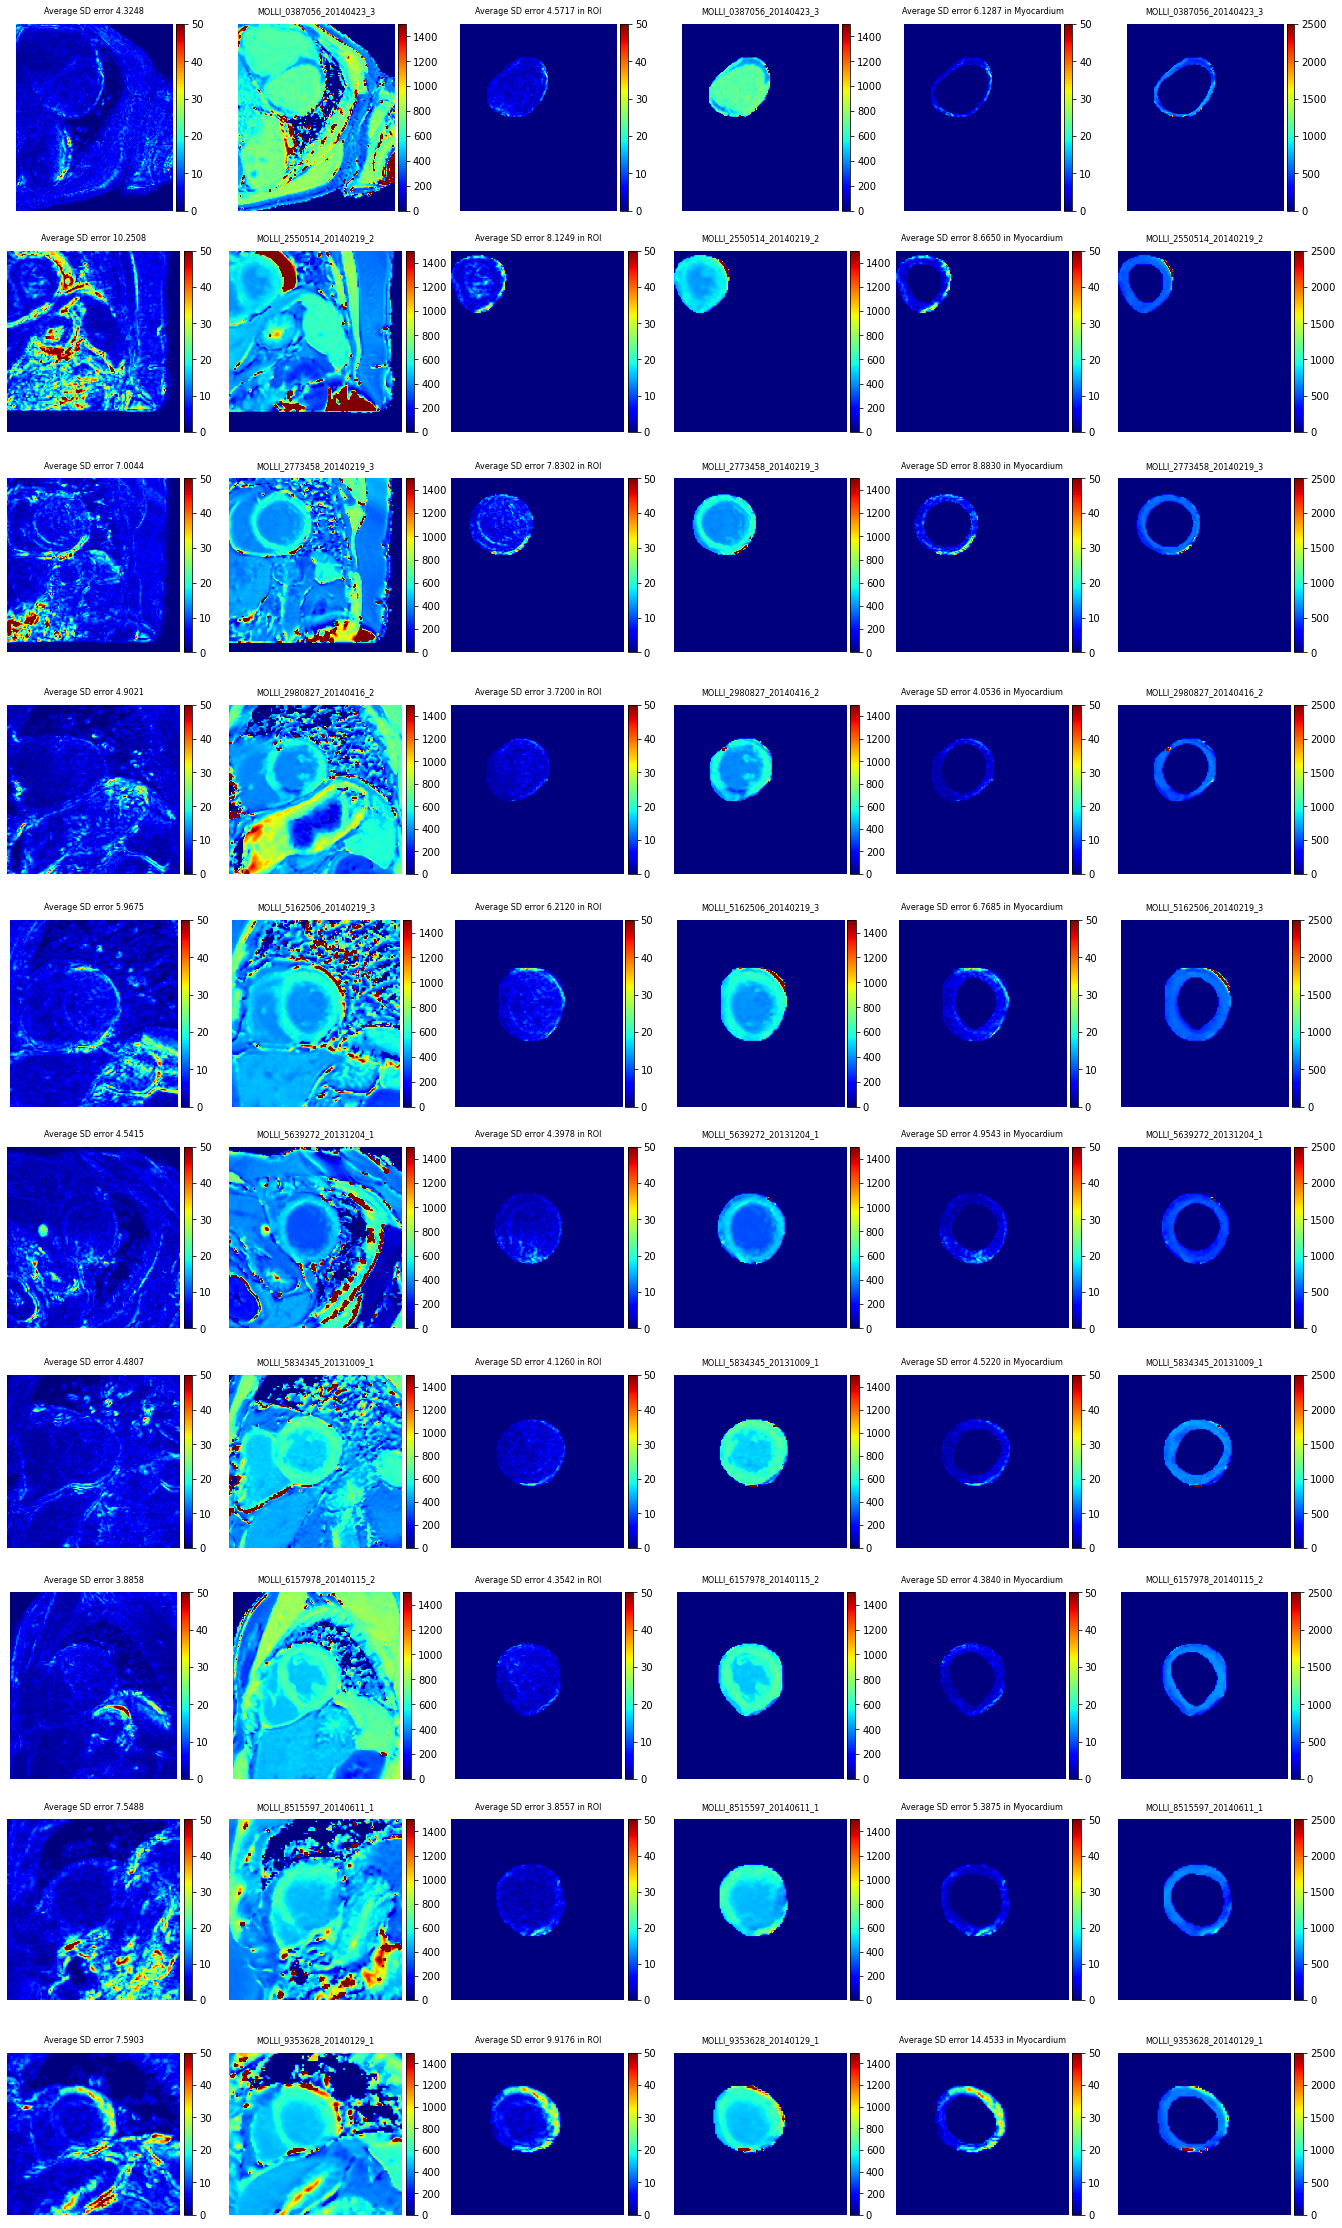

In [10]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R1 Square T1err'] = t1err_square_list
df['R1 ROI T1err'] = t1err_heart_list
df['R1 Myo T1err'] = t1err_myo_list
df_2['R1 PCA'] = pca_changes
df_2['R1 Det'] = mag_det_jac_det_list

### Round 2

In [11]:
r = 2
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [12]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8681665945004948 and std is 0.020758120943092685


#### Jacobian Determination

In [13]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0024273660965263844


#### T1 fitting

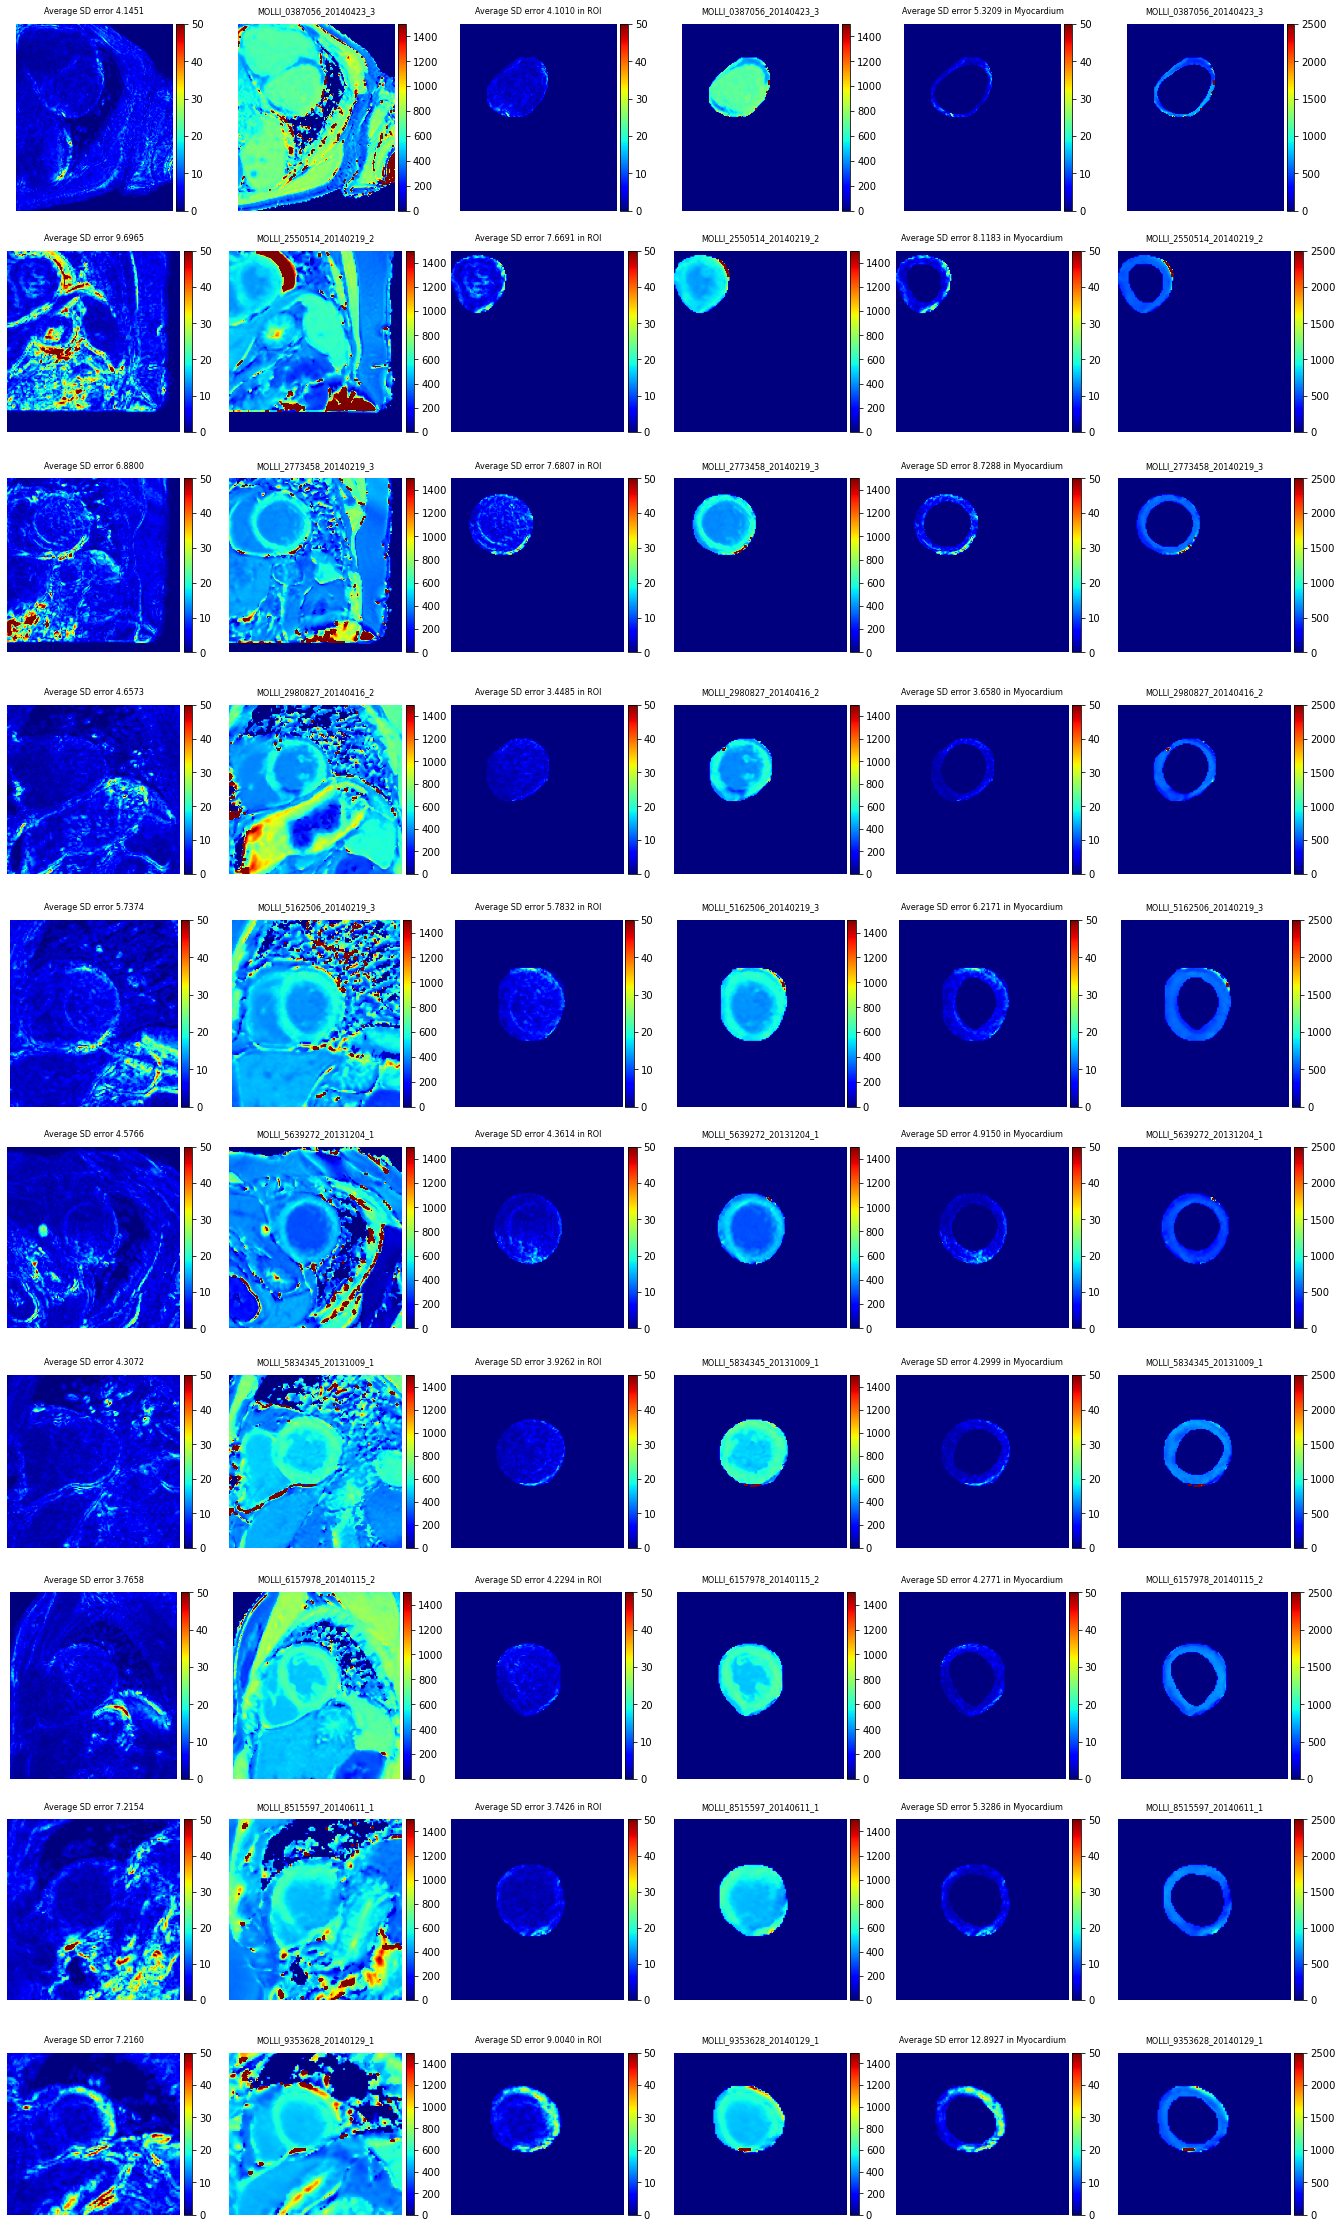

In [14]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R2 Square T1err'] = t1err_square_list
df['R2 ROI T1err'] = t1err_heart_list
df['R2 Myo T1err'] = t1err_myo_list
df_2['R2 PCA'] = pca_changes
df_2['R2 Det'] = mag_det_jac_det_list

### Round 3

In [15]:
r = 3
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [16]:
path = f"{base_path}/moved"
r5_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r5_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r5_pca_changes))} and std is {np.std(np.array(r5_pca_changes))}")

Mean of Round 2 PCA is 0.8692366209286766 and std is 0.020420859722874475


#### Jacobian Determination

In [17]:
r5_folding_ratio_list = []
r5_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r5_folding_ratio_list.append(folding_ratio)
    r5_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r5_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r5_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0013626785948872566


#### T1 fitting

In [18]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R3 Square T1err'] = t1err_square_list
df['R3 ROI T1err'] = t1err_heart_list
df['R3 Myo T1err'] = t1err_myo_list
df_2['R3 PCA'] = pca_changes
df_2['R3 Det'] = mag_det_jac_det_list

ValueError: Length of values (0) does not match length of index (10)

<Figure size 1440x2592 with 0 Axes>

### Round 4

In [ ]:
r = 4
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8693190524962772 and std is 0.020329571301474173


#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0011093617649748921


#### T1 fitting

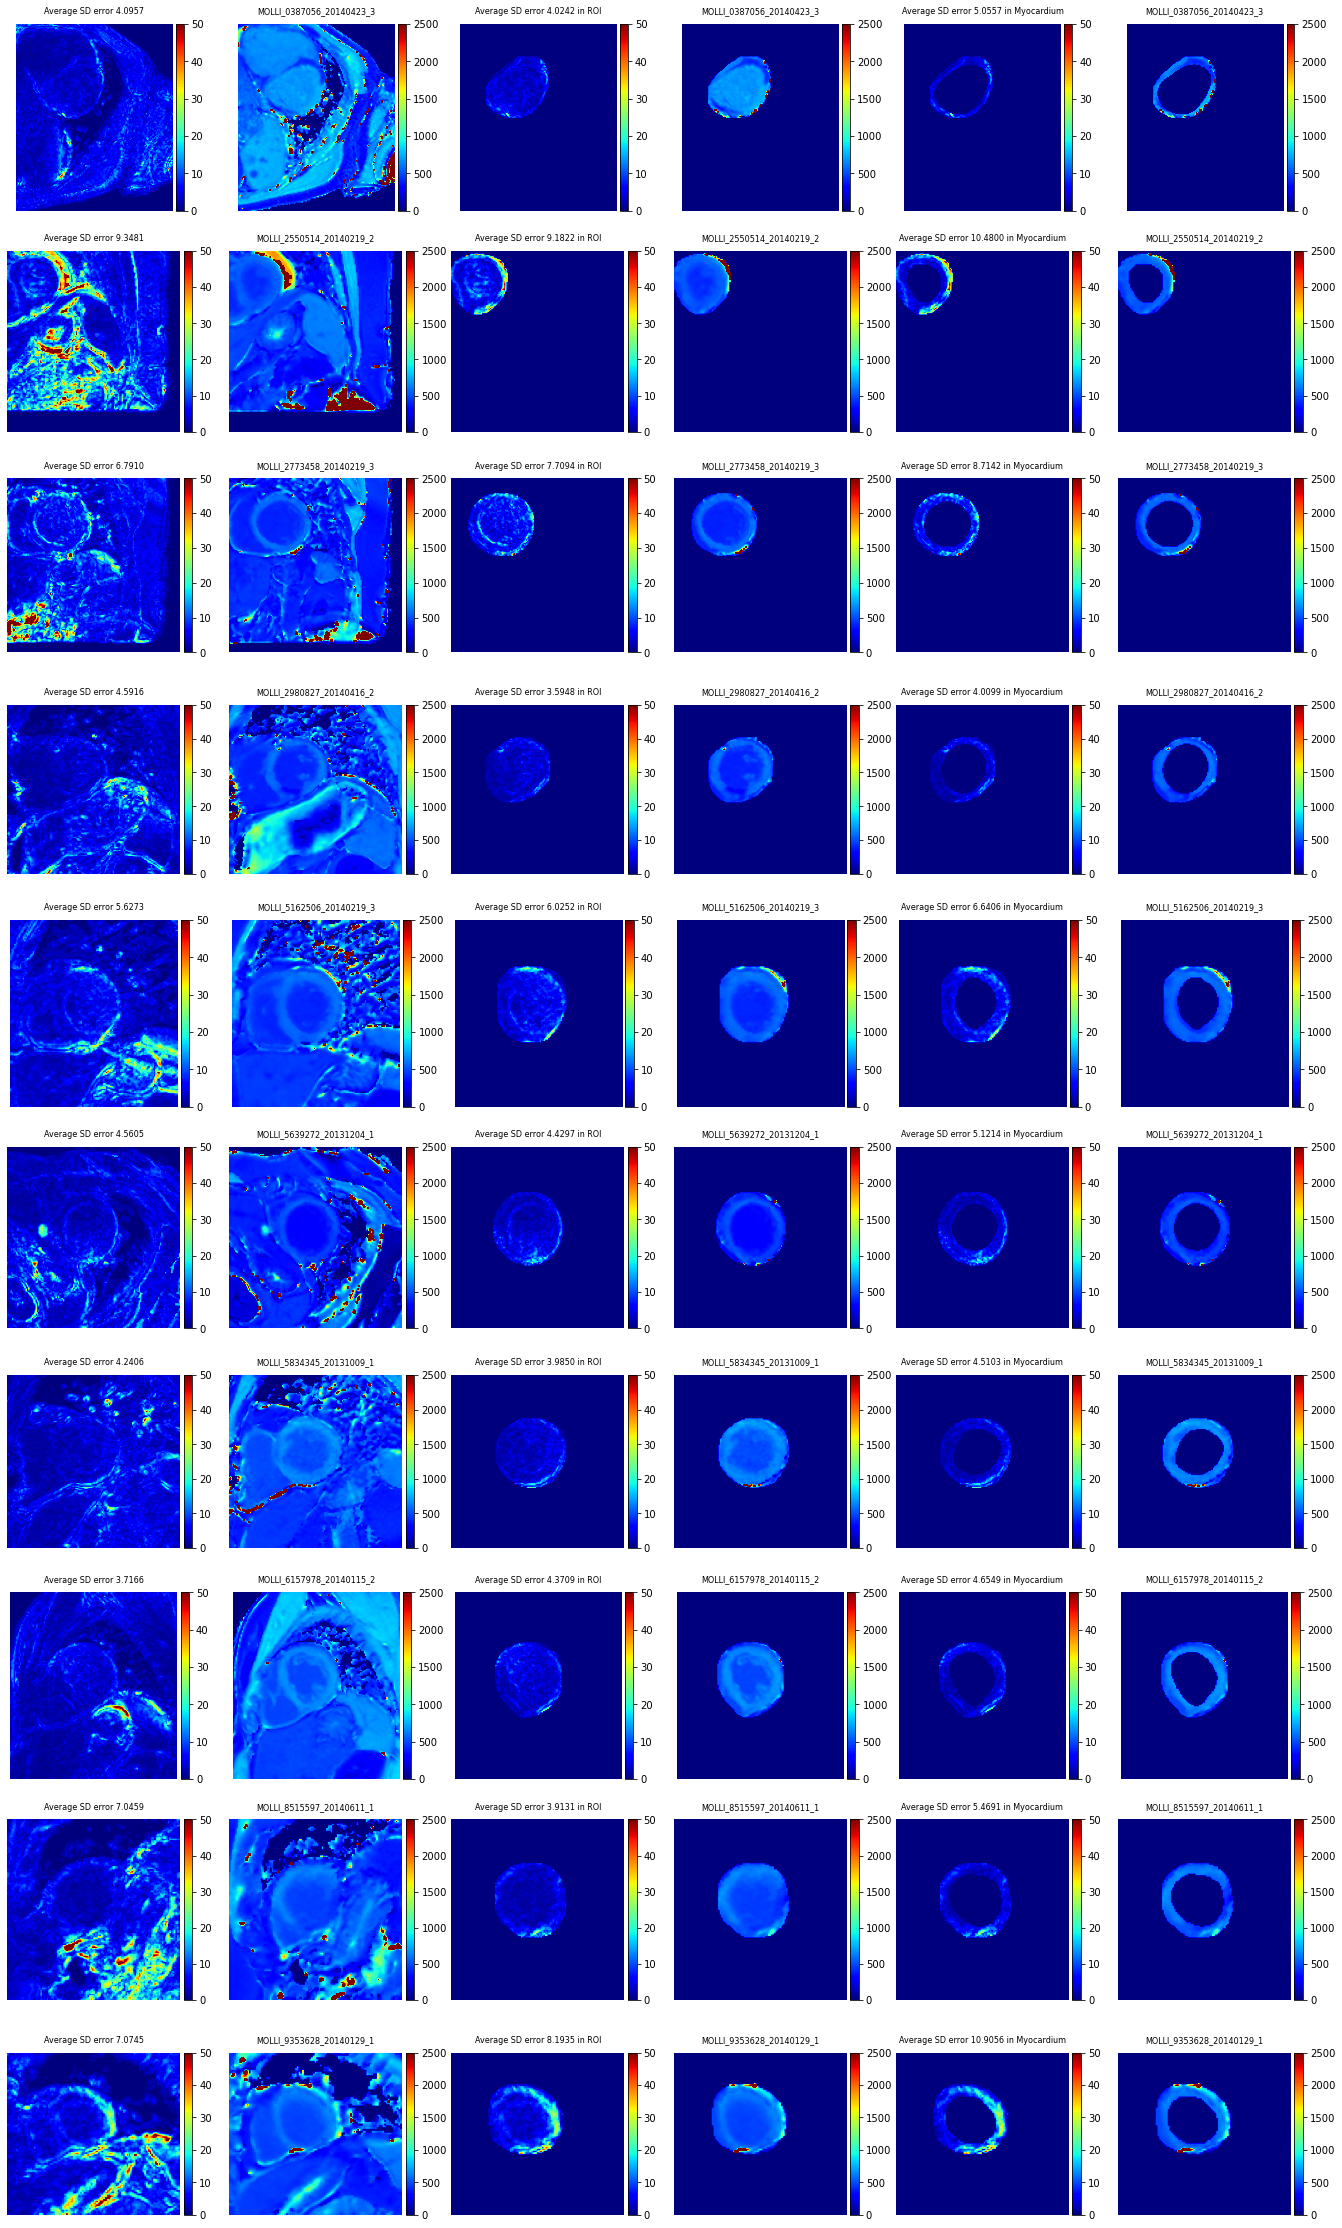

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R4 Square T1err'] = t1err_square_list
df['R4 ROI T1err'] = t1err_heart_list
df['R4 Myo T1err'] = t1err_myo_list
df_2['R4 PCA'] = pca_changes
df_2['R4 Det'] = mag_det_jac_det_list

### Round 5

In [ ]:
r = 5
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8702300096659318 and std is 0.020203357792493836


#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0009457830456085503


#### T1 fitting

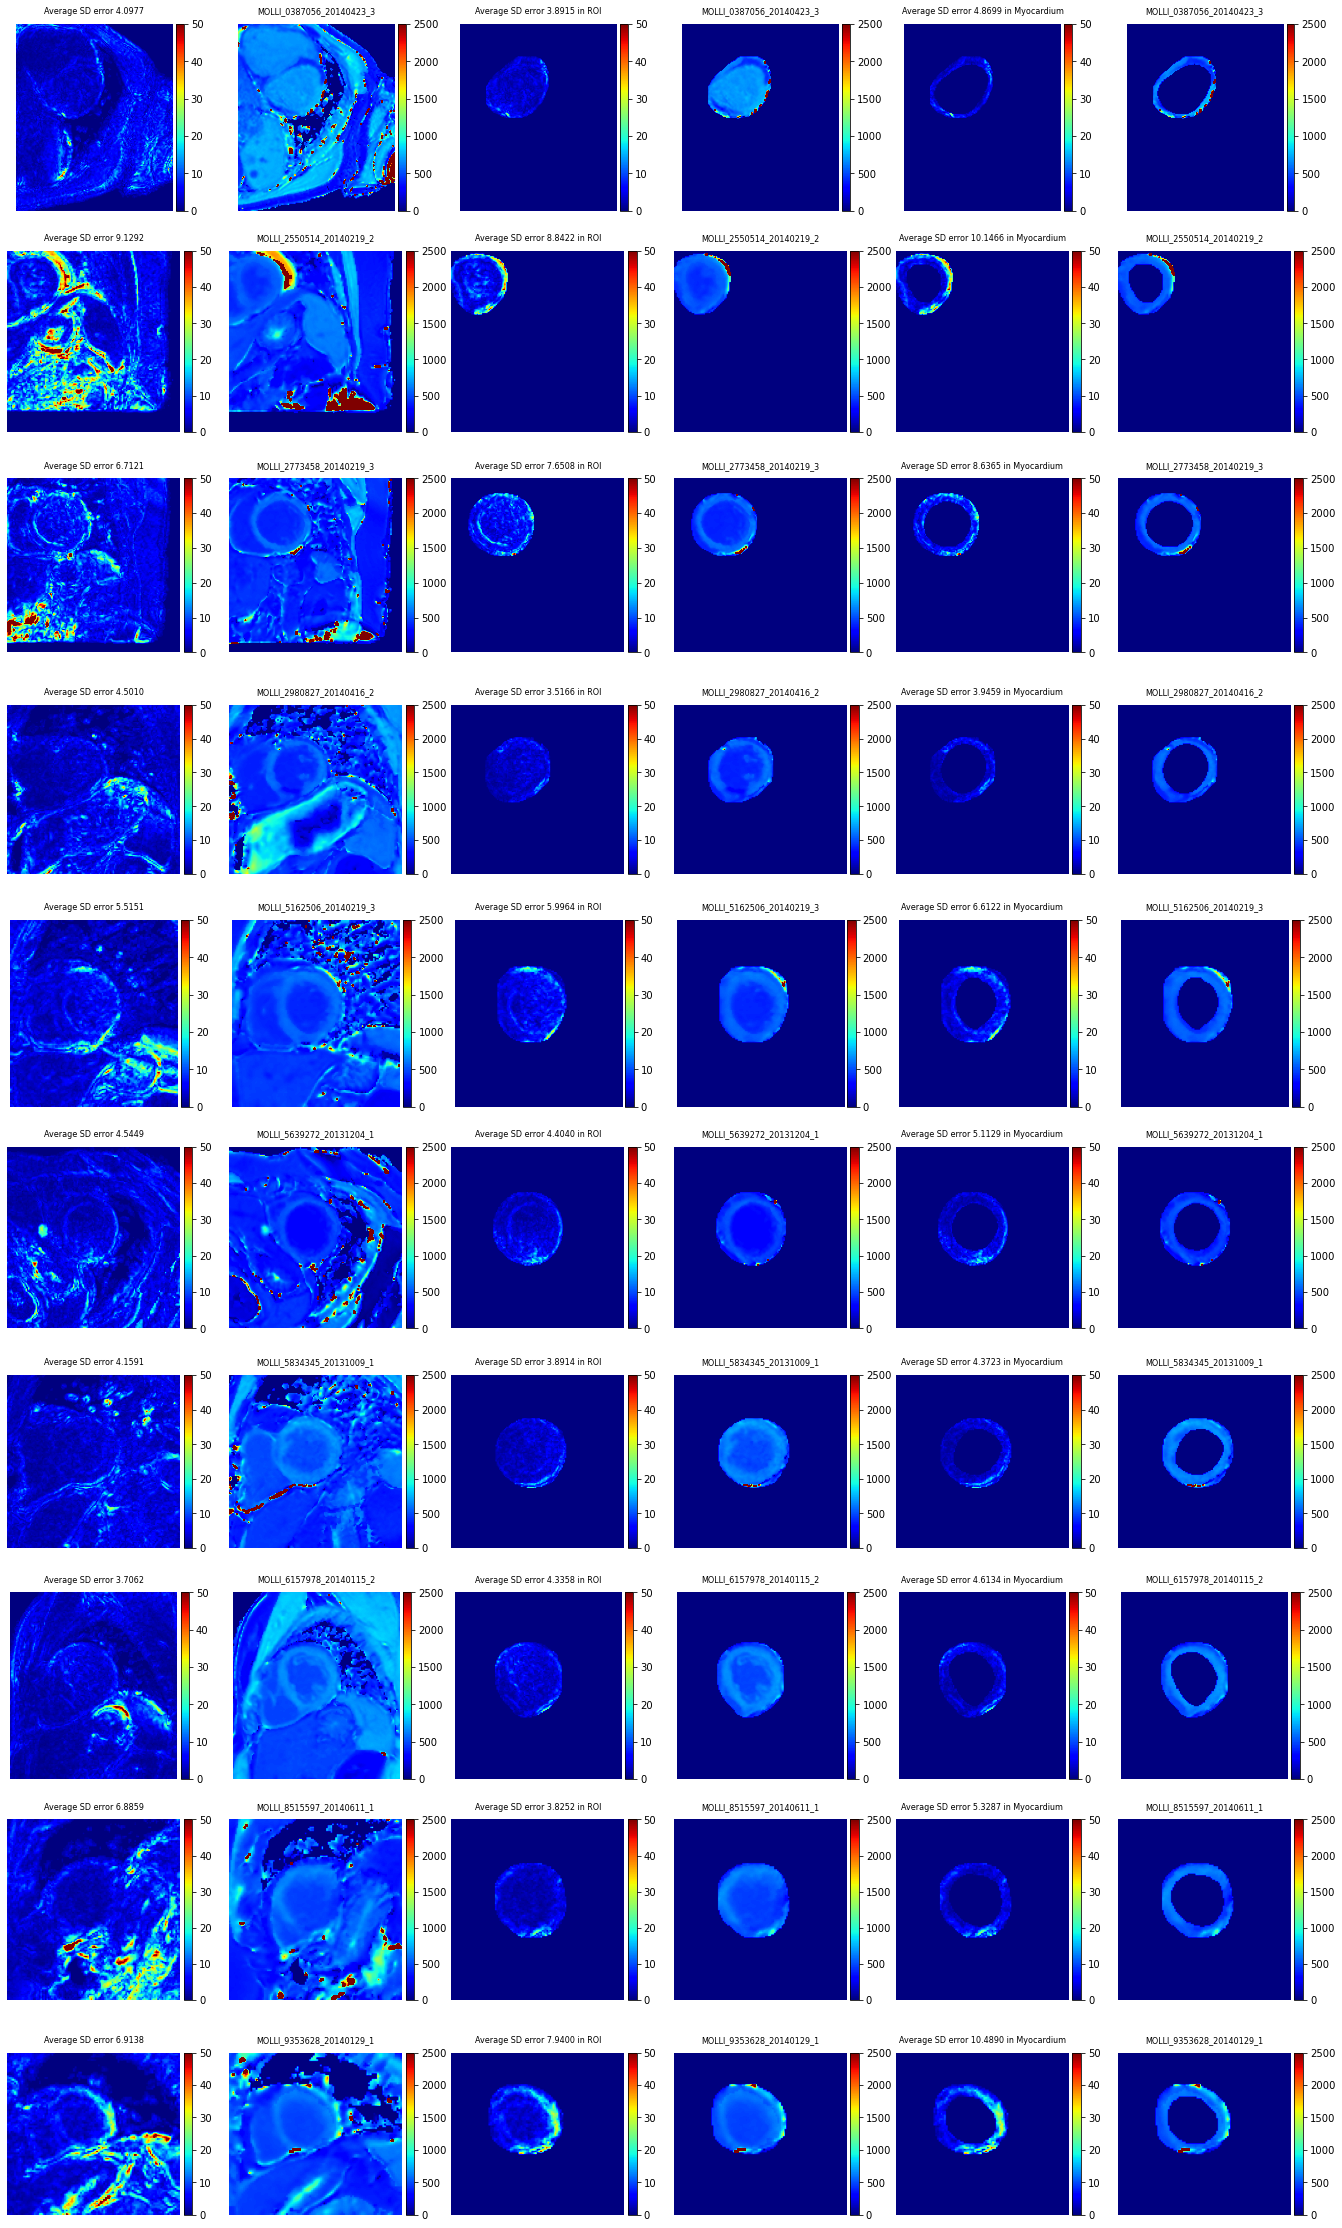

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R5 Square T1err'] = t1err_square_list
df['R5 ROI T1err'] = t1err_heart_list
df['R5 Myo T1err'] = t1err_myo_list
df_2['R5 PCA'] = pca_changes
df_2['R5 Det'] = mag_det_jac_det_list

### Round 6

In [ ]:
r = 6
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8709678191063391 and std is 0.020147851989549187


#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0008347457041963935


#### T1 fitting

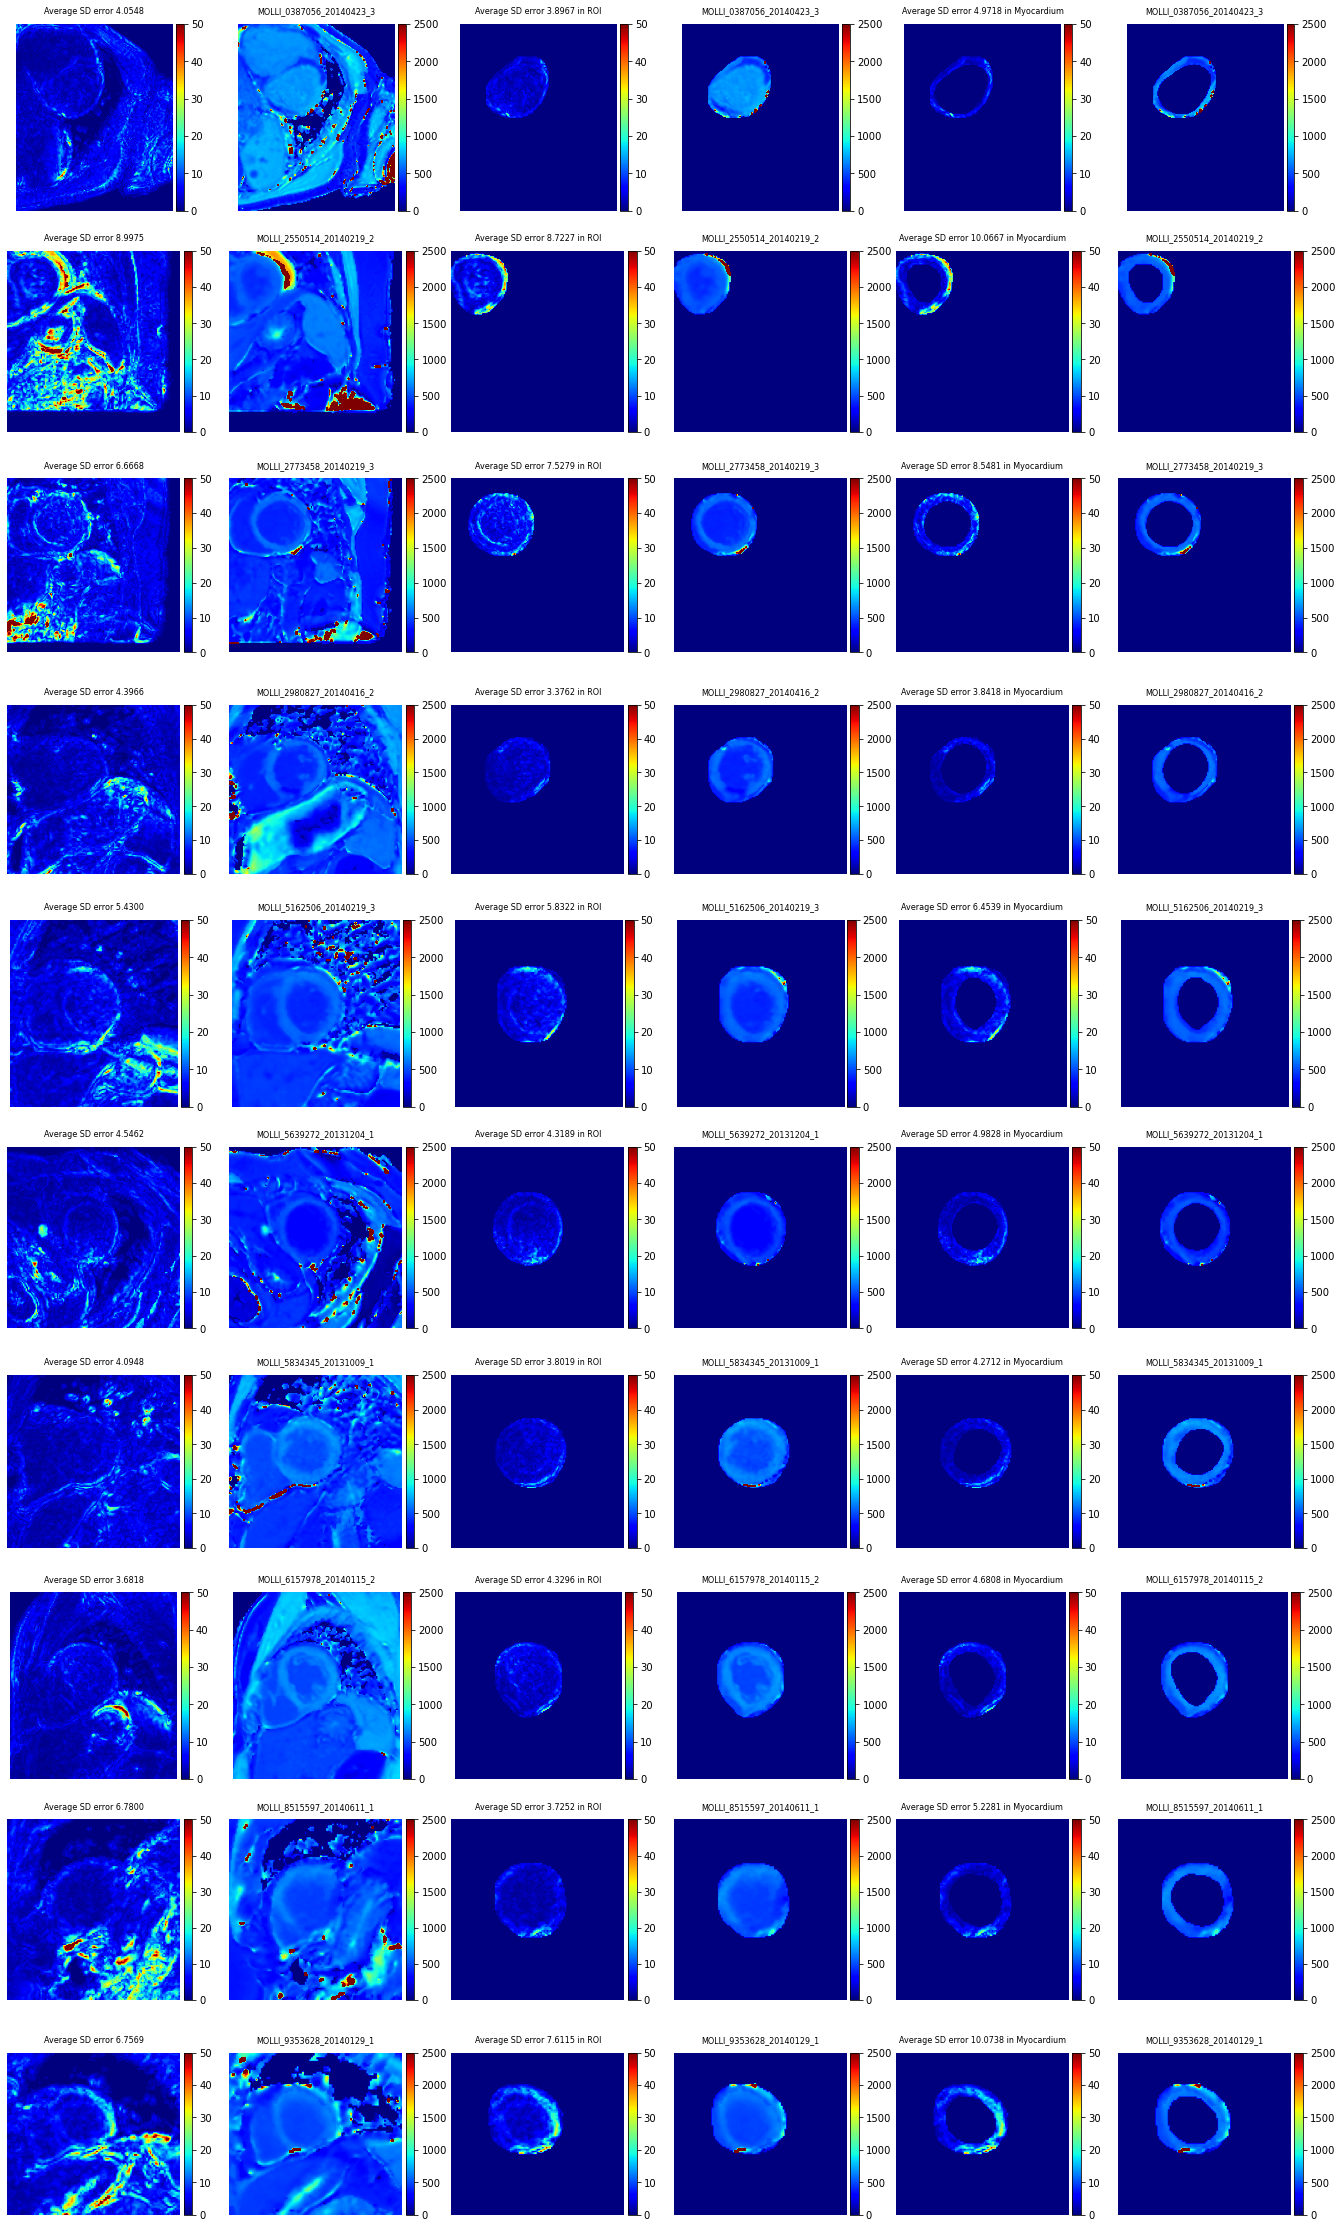

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R6 Square T1err'] = t1err_square_list
df['R6 ROI T1err'] = t1err_heart_list
df['R6 Myo T1err'] = t1err_myo_list
df_2['R6 PCA'] = pca_changes
df_2['R6 Det'] = mag_det_jac_det_list

### Round 7

In [ ]:
r = 7
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8714032266908764 and std is 0.020092518340981778


#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0006567054660990834


#### T1 fitting

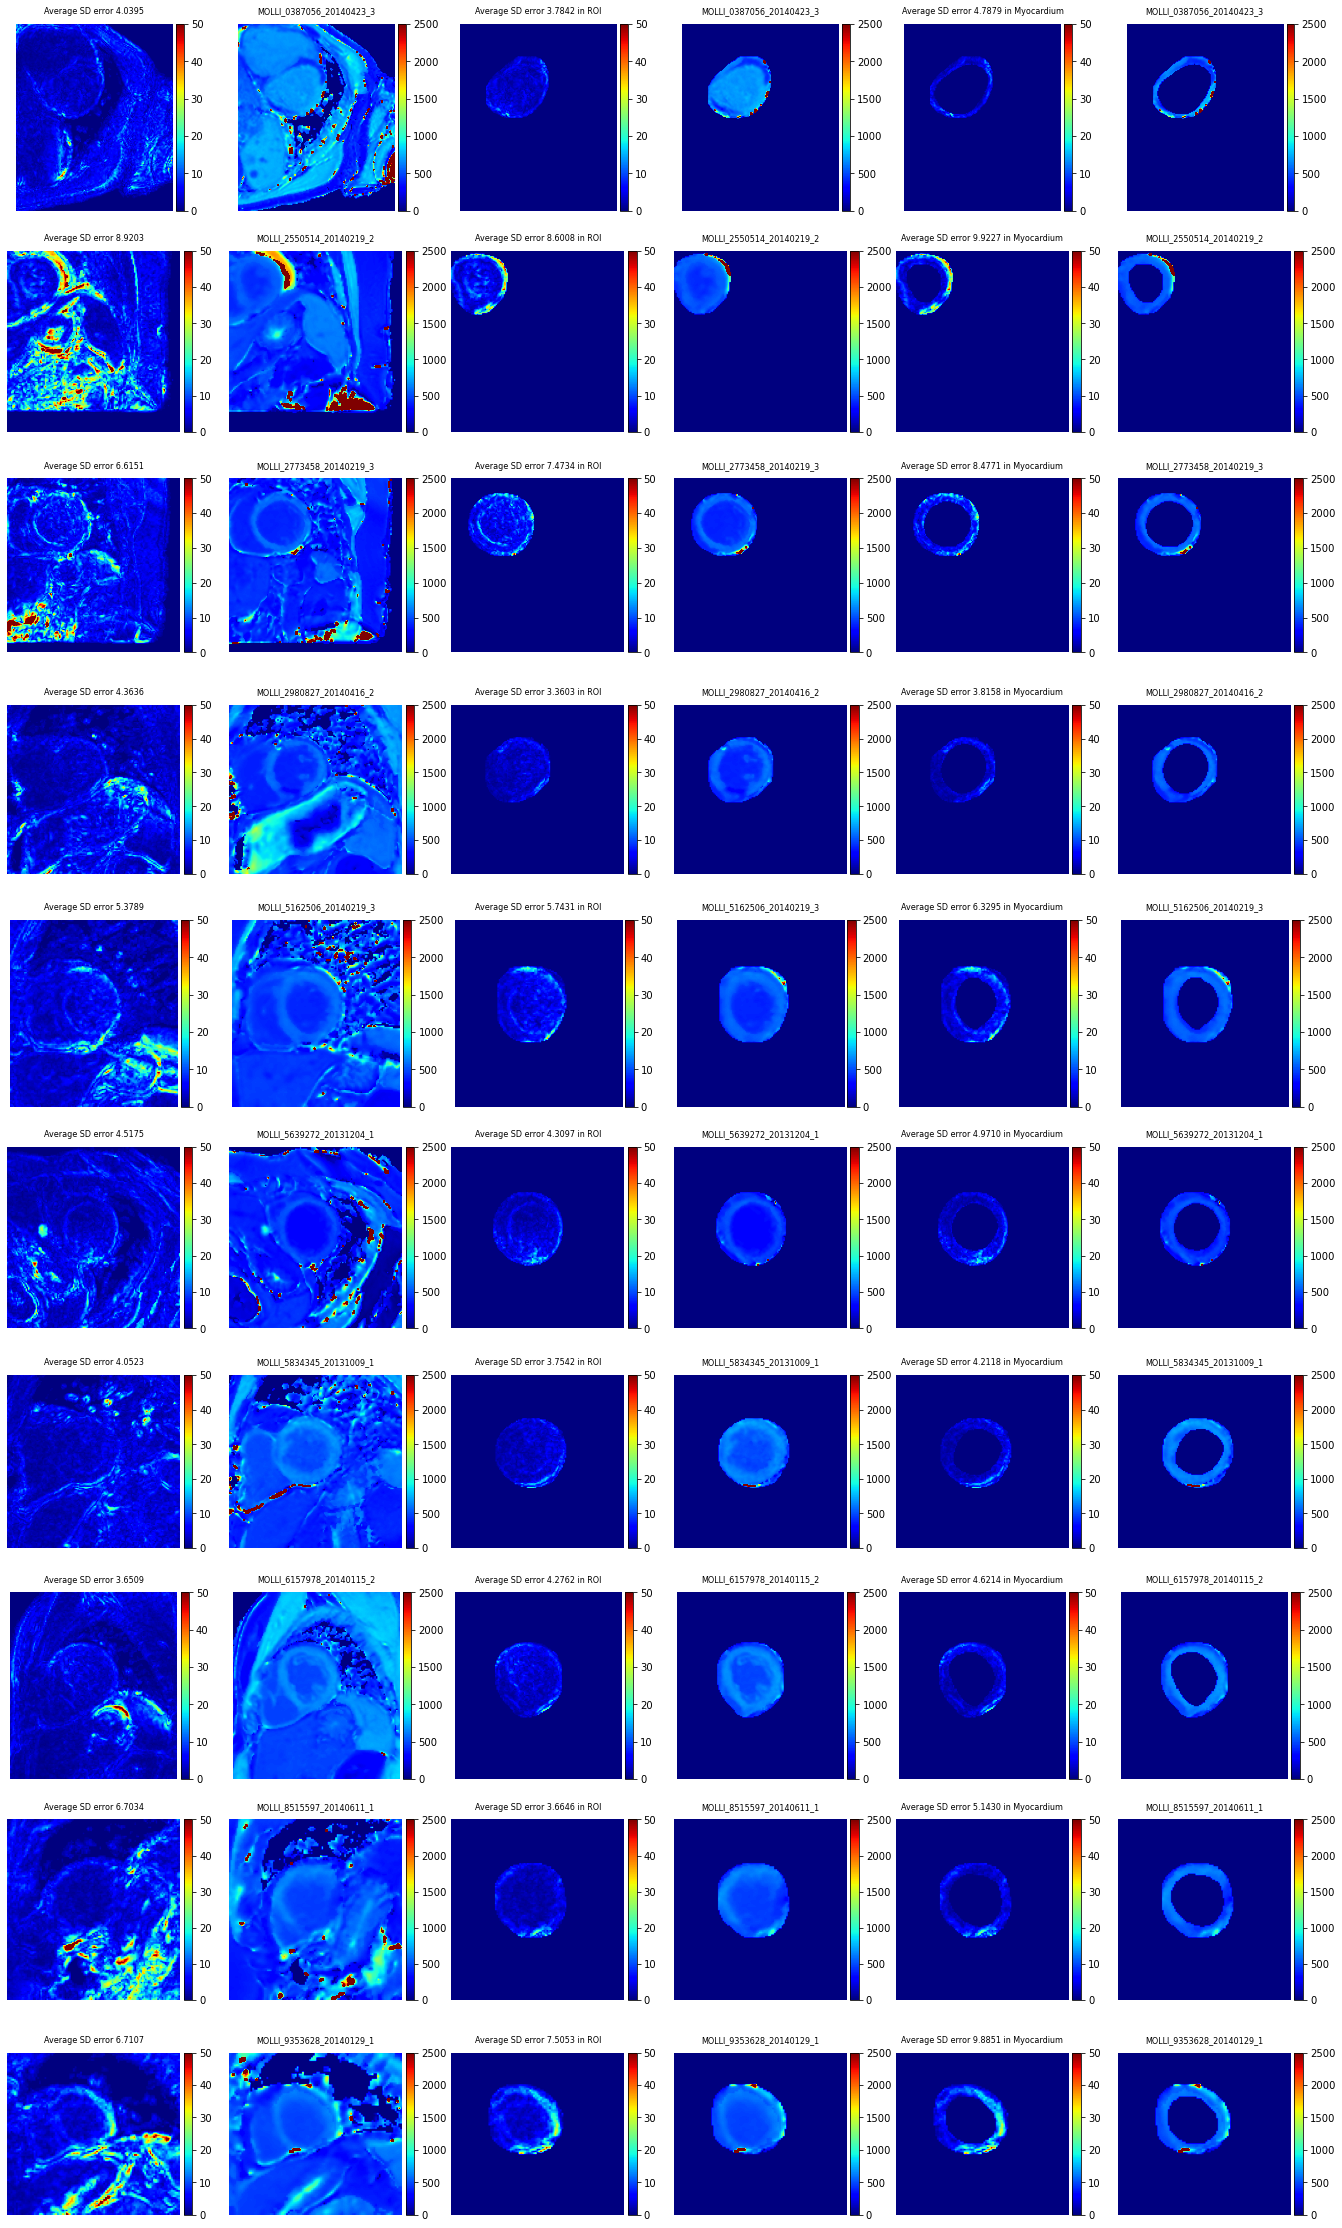

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R7 Square T1err'] = t1err_square_list
df['R7 ROI T1err'] = t1err_heart_list
df['R7 Myo T1err'] = t1err_myo_list
df_2['R7 PCA'] = pca_changes
df_2['R7 Det'] = mag_det_jac_det_list

### Summary

In [ ]:
df

Cases  Raw Square T1err  Raw ROI T1err  Raw Myo T1err  \
0  MOLLI_0387056_20140423_3          4.365528       4.750349       5.870213   
1  MOLLI_2550514_20140219_2         11.222237      11.078317      13.001846   
2  MOLLI_2773458_20140219_3          7.986917       9.714299      11.609513   
3  MOLLI_2980827_20140416_2          5.584256       4.158440       4.686161   
4  MOLLI_5162506_20140219_3          6.906262       6.659965       7.218737   
5  MOLLI_5639272_20131204_1          4.647820       4.714119       5.280648   
6  MOLLI_5834345_20131009_1          5.346733       4.869995       5.496672   
7  MOLLI_6157978_20140115_2          4.345653       5.046114       5.540035   
8  MOLLI_8515597_20140611_1          8.249505       4.466549       6.104468   
9  MOLLI_9353628_20140129_1          8.867598       9.884377      13.440048   

   R1 Square T1err  R1 ROI T1err  R1 Myo T1err  R2 Square T1err  R2 ROI T1err  \
0         4.198293      4.284384      5.191354         4.127298      4.186035   
1        10.464649     10.216728     11.839522         9.929897      9.795125   
2         7.205151      8.297101      9.259697         6.885583      8.046352   
3         5.132204      4.053254      4.568826         4.831367      3.812488   
4         6.134622      6.370912      6.947874         5.860113      6.316828   
5         4.589056      4.747381      5.536326         4.546763      4.467940   
6         4.682542      4.363724      4.888399         4.523443      4.214228   
7         3.911572      4.717144      5.122597         3.790419      4.514896   
8         7.816573      4.292095      5.949366         7.328532      4.113848   
9         7.945542      9.482933     12.806998         7.540527      9.018457   

   R2 Myo T1err  ...  R4 Myo T1err  R5 Square T1err  R5 ROI T1err  \
0      5.113232  ...      5.055747         4.097733      3.891542   
1     11.160769  ...     10.480006         9.129202      8.842205   
2      8.944992  ...      8.714223         6.712078      7.650752   
3      4.197465  ...      4.009947         4.500976      3.516566   
4      6.935497  ...      6.640610         5.515110      5.996352   
5      5.167709  ...      5.121441         4.544875      4.404017   
6      4.774812  ...      4.510279         4.159082      3.891415   
7      4.794950  ...      4.654905         3.706219      4.335840   
8      5.721366  ...      5.469054         6.885938      3.825216   
9     12.223480  ...     10.905570         6.913776      7.940010   

   R5 Myo T1err  R6 Square T1err  R6 ROI T1err  R6 Myo T1err  R7 Square T1err  \
0      4.869881         4.054785      3.896691      4.971790         4.039510   
1     10.146564         8.997479      8.722657     10.066715         8.920295   
2      8.636531         6.666790      7.527919      8.548095         6.615144   
3      3.945909         4.396617      3.376232      3.841777         4.363575   
4      6.612217         5.430037      5.832170      6.453873         5.378864   
5      5.112860         4.546249      4.318939      4.982795         4.517464   
6      4.372347         4.094843      3.801934      4.271213         4.052333   
7      4.613386         3.681800      4.329562      4.680754         3.650892   
8      5.328721         6.780045      3.725181      5.228139         6.703411   
9     10.488994         6.756882      7.611496     10.073792         6.710745   

   R7 ROI T1err  R7 Myo T1err  
0      3.784189      4.787931  
1      8.600769      9.922670  
2      7.473399      8.477136  
3      3.360311      3.815830  
4      5.743080      6.329542  
5      4.309706      4.971006  
6      3.754180      4.211799  
7      4.276168      4.621351  
8      3.664566      5.143014  
9      7.505340      9.885130  

[10 rows x 25 columns]

In [ ]:
df_ROI_desc = pd.DataFrame()
df_ROI_desc['Cases'] = df['Cases']
for round in range(1, 8):
    df_ROI_desc[f'R{round}/Raw ROI %'] = (df['Raw ROI T1err'] - df[f'R{round} ROI T1err']) / df['Raw ROI T1err']
df_ROI_desc.describe()

R1/Raw ROI %  R2/Raw ROI %  R3/Raw ROI %  R4/Raw ROI %  R5/Raw ROI %  \
count     10.000000     10.000000     10.000000     10.000000     10.000000   
mean       0.063221      0.099976      0.122394      0.143210      0.159683   
std        0.044459      0.037245      0.038836      0.043213      0.048472   
min       -0.007056      0.051522      0.062058      0.060343      0.065782   
25%        0.039447      0.080022      0.101683      0.126380      0.141464   
50%        0.054297      0.096439      0.119315      0.144203      0.167571   
75%        0.093011      0.118053      0.145244      0.171132      0.199883   
max        0.145888      0.171700      0.193321      0.206383      0.212424   

       R6/Raw ROI %  R7/Raw ROI %  
count     10.000000     10.000000  
mean       0.177088      0.187504  
std        0.048431      0.049570  
min        0.083829      0.085788  
25%        0.147996      0.159325  
50%        0.183903      0.197659  
75%        0.217645      0.227750  
max        0.229947      0.240687

In [ ]:
df_Myo_desc = pd.DataFrame()
df_Myo_desc['Cases'] = df['Cases']
for round in range(1, 8):
    df_Myo_desc[f'R{round}/Raw Myo %'] = (df['Raw Myo T1err'] - df[f'R{round} Myo T1err']) / df['Raw Myo T1err']
df_Myo_desc.describe()

R1/Raw Myo %  R2/Raw Myo %  R3/Raw Myo %  R4/Raw Myo %  R5/Raw Myo %  \
count     10.000000     10.000000     10.000000     10.000000     10.000000   
mean       0.068011      0.108407      0.126643      0.146852      0.163832   
std        0.067696      0.059790      0.060364      0.062965      0.068015   
min       -0.048418      0.021387      0.033282      0.030149      0.031774   
25%        0.028437      0.069698      0.090957      0.112754      0.134800   
50%        0.061226      0.116619      0.129170      0.152035      0.168836   
75%        0.105346      0.133700      0.143806      0.186296      0.215815   
max        0.202404      0.229512      0.247529      0.249389      0.256082   

       R6/Raw Myo %  R7/Raw Myo %  
count     10.000000     10.000000  
mean       0.175711      0.188013  
std        0.065960      0.066165  
min        0.056405      0.058637  
25%        0.145929      0.159582  
50%        0.167645      0.185046  
75%        0.225047      0.236058  
max        0.263699      0.269811

In [ ]:
df_PCA_desc = pd.DataFrame()
df_PCA_desc['Cases'] = df_2['Cases']
for round  in range(1, 8):
    df_PCA_desc[f'R{round}/Raw PCA %'] = (df_2[f'R{round} PCA'] - df_2['Raw PCA']) / df_2['Raw PCA']
df_PCA_desc.describe()

R1/Raw PCA %  R2/Raw PCA %  R3/Raw PCA %  R4/Raw PCA %  R5/Raw PCA %  \
count     10.000000     10.000000     10.000000     10.000000     10.000000   
mean       0.005587      0.008795      0.008795      0.012063      0.013129   
std        0.002534      0.003226      0.003226      0.004374      0.004639   
min        0.002592      0.004062      0.004062      0.004908      0.005482   
25%        0.003469      0.006322      0.006322      0.009529      0.010368   
50%        0.005069      0.009125      0.009125      0.011719      0.012717   
75%        0.007407      0.010685      0.010685      0.015149      0.016419   
max        0.010434      0.014354      0.014354      0.019650      0.021205   

       R6/Raw PCA %  R7/Raw PCA %  
count     10.000000     10.000000  
mean       0.013990      0.014499  
std        0.004735      0.004837  
min        0.006146      0.006335  
25%        0.011226      0.011761  
50%        0.013755      0.014267  
75%        0.017193      0.017734  
max        0.022177      0.022843

In [ ]:
df_det = df_2[['R1 Det', 'R2 Det', 'R3 Det', 'R4 Det', 'R5 Det', 'R6 Det', 'R7 Det']]
df_det.describe()

R1 Det     R2 Det     R3 Det     R4 Det     R5 Det     R6 Det  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.002269   0.001603   0.001603   0.001109   0.000946   0.000835   
std     0.000233   0.000151   0.000151   0.000088   0.000039   0.000050   
min     0.001832   0.001334   0.001334   0.000898   0.000887   0.000755   
25%     0.002118   0.001534   0.001534   0.001087   0.000934   0.000808   
50%     0.002286   0.001622   0.001622   0.001118   0.000947   0.000827   
75%     0.002434   0.001685   0.001685   0.001145   0.000961   0.000860   
max     0.002570   0.001830   0.001830   0.001236   0.001018   0.000926   

          R7 Det  
count  10.000000  
mean    0.000657  
std     0.000048  
min     0.000595  
25%     0.000623  
50%     0.000648  
75%     0.000684  
max     0.000751